### Trabajo Práctico N°1

In [367]:
## Importamos librerías
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unidecode
from nltk.util import ngrams
import nltk, re, string, collections
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
sns.set(style="whitegrid")

In [368]:
##Leemos el csv
df = pd.read_csv('train.csv')

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [370]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [371]:
#Chequeo que no tengamos id repetidas
df.id.unique().size

7613

### Preprocesamiento de Keywors y Tweets

In [375]:
#Exploramos un poco los tweets
from IPython.core.display import HTML
tweets = df['text'].tail(6).values;
for tweet in tweets:
    display(HTML(tweet+"<hr>"))

In [376]:
df['Cant_Palabras_sin_Depurar'] = df.apply(lambda row: len(word_tokenize((row['text']))),axis=1)
df['Cant_Oraciones'] = df.apply(lambda row: len(sent_tokenize((row['text']))),axis=1)
df['Longitud_Tweet_sin_Depurar'] = df.apply(lambda row: len(row['text']),axis=1)

In [377]:
df.keyword.fillna('other',inplace=True)
def limpieza_texto(df,name_col):
    #saco todos los links
    df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub(r'https?://\S+', '', s))
    #saco todo lo que sea codigo HTML
    #df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub('<.*?>', '', s))
    # saco todo lo que no sea alfanumerico
    df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub(r'[^\w]', ' ', s))
    # lo paso a minuscula
    df.loc[:,name_col] = df[name_col].apply(lambda s: s.lower())
    # paso a unicode
    #df.loc[:,name_col] = df[name_col].apply(lambda s: unidecode.unidecode(s))  
    
    if name_col == 'keyword':
        # quito el numero 20 que aparece en la keyword
        df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub('20', ' ', s))
    # saco los espacios en blanco de mas
    df.loc[:,name_col] = df[name_col].apply(lambda s: re.sub(' +',' ',s))
    return df

df = limpieza_texto(df,'text')
df = limpieza_texto(df,'keyword')

In [378]:
df['Cant_Palabras_Depuradas'] = df.apply(lambda row: len(word_tokenize((row['text']))),axis=1)
df['Longitud_Tweet_Depurado'] = df.apply(lambda row: len(row['text']),axis=1)

In [379]:
#Exploramos un poco los tweets
from IPython.core.display import HTML
tweets = df['text'].tail(6).values;
for tweet in tweets:
    display(HTML(tweet+"<hr>"))

#### Vamos a intentar completar las 61 Keywors nulas, a las que habíamos asignado 'other', fijándonos en los tweets y analizando si contienen una de las Keywords existentes.

In [380]:
mi_lista =["building burning","buildings burning", "buildings on fire","buldings","flames","bush fire","wildfire","hellfire","fire","truck fire","wild fires","bush fires","forest fires","arson","arsonist","burning","ablaze","blazing","blaze","burned"\
,"accident","airplane accident","bridge collapse","oil spill","collapse","electrocuted","electrocute","cliff fall","traped","collapsed","crashed","crushed","crush","wrecked","wreckage","wreck","collide","collided","collision","crash"\
,"apocalypse","armageddon","annihilated","annihilation","catastrophic","famine","ruin","catastrophe","razed","devastation","disaster","heat wave","pandemonium","destruction","desolation","desolate","destroyed","destroy","blight","demolition"\
,"terrorism","bioterror","bioterrorism","terrorist","threat","hijacker","hijacking","mass murder","mass murderer","massacre","massac","hostage","attack","hijack","attacked","detonate","suicide bomber","suicide bomb","blown up","suicide bombing","blew up", "blow up","bombing","bomb","bombed","exploded","explosion","explode"\
,"fatality","fatal","fatalities","casualty","casualties","deaths","death","drown","drowned", "drowning","drownet","tragedy","trauma","traumatised","blood","bleeding","dead","bloody","body bagging","body bag","body bags"\
,"thunderstorm","storm","twister","typhoon","hurricane","tornado","windstorm","rainstorm","sandstorm","hailstorm","hail","earthquake","flooding","mudslide","seismic","floods","inundated","inundation","landslide","lava","lightning","flood","thunder","tsunami","cyclone","deluge","snowstorm","avalanche","blizzard","whirlwind","volcano","drought"\
,"survivors","survivor","survive","survived","refugees","rescue","rescued","rescuers","wounded","deluged","derailed","flattened","harm"\
,"army","battle","military","police","weapons","weapon","war zone","hostages","mayhem","detonation","devastated","displaced","first responders","eyewitness","engulfed","injured","injuries","injury","obliterate","obliterated","obliteration"\
,"danger","damage","curfew","debris","trouble","demolish","meltdown","aftershock","nuclear reactor","structural failure","smoke","rubble","sinking","sinkhole","hazardous","hazard","fear","demolished","derail","derailet","derailment","epicentre","loud bang","rioting","riot"\
,"emergency","services emergency","plan emergency","ambulance","chemical emergency","evacuate","upheaval","sirens","wounds","siren","stretcher","evacuated","evacuation","outbreak","panic","screamed","screaming","screams","panicking"\
,"quarantine","quarantined"]

def encuentra_key(tweet): 
    for s in tweet:
        if s in mi_lista:
            return s
    return 'other'    

key_aux = df.loc[df['keyword']=='other',['keyword','text']]
key_aux['text'] = key_aux['text'].map(lambda x: x.lower())
key_aux['text'] = key_aux['text'].map(lambda x: x.split())
key_aux['keyword']=key_aux['text'].map(encuentra_key)

In [381]:
key_aux.keyword.values

array(['earthquake', 'fire', 'evacuation', 'evacuation', 'smoke', 'fire',
       'flood', 'fire', 'emergency', 'tornado', 'other', 'flooding',
       'flooding', 'flood', 'damage', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'bomb', 'explode',
       'police', 'seismic', 'sirens', 'attack', 'earthquake', 'typhoon',
       'other', 'other', 'other', 'exploded', 'flood', 'thunderstorm',
       'debris', 'collided', 'earthquake', 'evacuation', 'other', 'siren',
       'quarantine', 'fire', 'bomb', 'other', 'tornado', 'collapse',
       'other', 'volcano', 'police', 'razed'], dtype=object)

In [484]:
len(key_aux['keyword'])

61

In [489]:
key_aux.loc[key_aux['keyword']!='other',:].shape[0]

38

>* de los 61 registros con keyword = 'other' a 38 logramos encontrale una keyword

In [383]:
df.loc[df['keyword']=='other','keyword'] = key_aux['keyword']

### Creamos una Key Global, a modo de concepto, que trate de sectorizar a las keywords para luego realizar análisis con un meyor detalle.

In [384]:
mis_kw = df['keyword']

In [385]:
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()
keyword_dict = {"Burning": ["building burning","buildings burning", "buildings on fire","buldings","flames","bush fire","wildfire","hellfire","fire","truck fire","wild fires","bush fires","forest fires","arson","arsonist","burning","ablaze","blazing","blaze","burned"]\
               ,"Accident": ["accident","airplane accident","bridge collapse","oil spill","collapse","electrocuted","electrocute","cliff fall","traped","trapped","collapsed","crashed","crushed","crush","wrecked","wreckage","wreck","collide","collided","collision","crash"]\
               ,"Apocalypse": ["apocalypse","armageddon","annihilated","annihilation","catastrophic","famine","ruin","catastrophe","razed","devastation","disaster","heat wave","pandemonium","destruction","desolation","desolate","destroyed","destroy","blight","demolition"]\
               ,"Attack": ["terrorism","bioterror","bioterrorism","terrorist","threat","hijacker","hijacking","mass murder","mass murderer","massacre","massac","hostage","attack","hijack","attacked","detonate","suicide bomber","suicide bomb","blown up","suicide bombing","blew up", "blow up","bombing","bomb","bombed","exploded","explosion","explode"]\
               ,"Fatality": ["fatality","fatal","fatalities","casualty","casualties","deaths","death","drown","drowned", "drowning","drownet","tragedy","trauma","traumatised","blood","bleeding","dead","bloody","body bagging","body bag","body bags","sunk"]\
               ,"Natural Phenomenon": ["thunderstorm","storm","twister","typhoon","hurricane","tornado","windstorm","rainstorm","sandstorm","hailstorm","hail","earthquake","flooding","mudslide","seismic","floods","inundated","inundation","landslide","lava","lightning","flood","thunder","tsunami","cyclone","deluge","snowstorm","avalanche","blizzard","whirlwind","volcano","drought"]\
               ,"Survivor": ["survivors","survivor","survive","survived","refugees","rescue","rescued","rescuers","wounded","deluged","derailed","flattened","harm"]\
               ,"Security": ["army","battle","military","police","weapons","weapon","war zone","hostages","mayhem","detonation","devastated","displaced","first responders","eyewitness","engulfed","injured","injuries","injury","obliterate","obliterated","obliteration"]\
               ,"Danger": ["danger","damage","curfew","debris","trouble","demolish","meltdown","aftershock","nuclear reactor","structural failure","smoke","rubble","sinking","sinkhole","hazardous","hazard","fear","demolished","derail","derailet","derailment","epicentre","loud bang","rioting","riot"]\
               ,"Emergency": ["emergency","services emergency","plan emergency","ambulance","chemical emergency","evacuate","upheaval","sirens","wounds","siren","stretcher","evacuated","evacuation","outbreak","panic","screamed","screaming","screams","panicking","quarantine","quarantined"]\
               ,"Otro": ["other"]}
key_depuradas=[]
keyword_processor.add_keywords_from_dict(keyword_dict)
for w in mis_kw:
       if len(keyword_processor.extract_keywords(w))==1:
            key_depuradas.append(keyword_processor.extract_keywords(w)[0])
       
       else: 
            key_depuradas.append(w)

In [386]:
len(key_depuradas)

7613

In [387]:
df['key_global'] = key_depuradas

In [388]:
df.key_global.unique()

array(['Natural Phenomenon', 'Burning', 'Emergency', 'Danger', 'Otro',
       'Accident', 'Apocalypse', 'Security', 'Attack', 'Fatality',
       'Survivor'], dtype=object)

'Diagrama de flujo de KeyWors Globales en relacion a la veracidad de los Tweets'

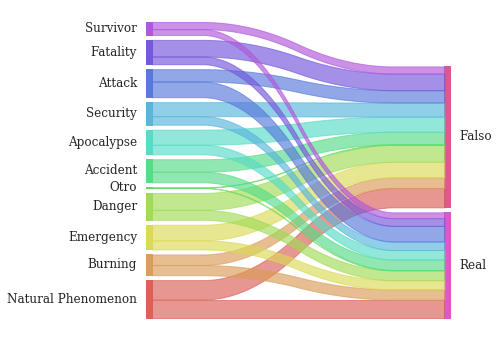

In [390]:
df['Veracidad']= '' 
df.loc[df['target']== 1,'Veracidad']= 'Real'
df.loc[df['target']== 0,'Veracidad']= 'Falso'
from pySankey import sankey
display('Diagrama de flujo de KeyWors Globales en relacion a la veracidad de los Tweets')
sankey.sankey(df['key_global'],df['Veracidad'],aspect=20, fontsize=12)

### Análisis de KeyWord

> * Un primer análisis para tener una idea de cuáles son las palabras más frecuentes de KeyWord y key_global utilizamos Wordcloud.

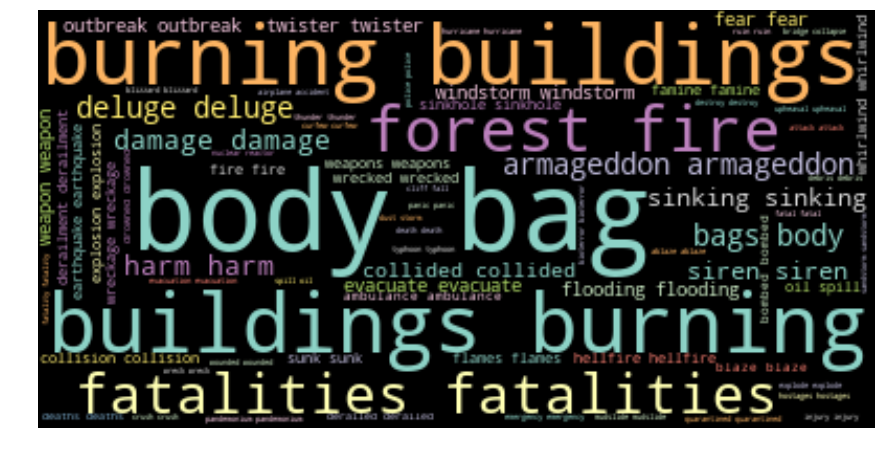

In [391]:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in df['keyword'])
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

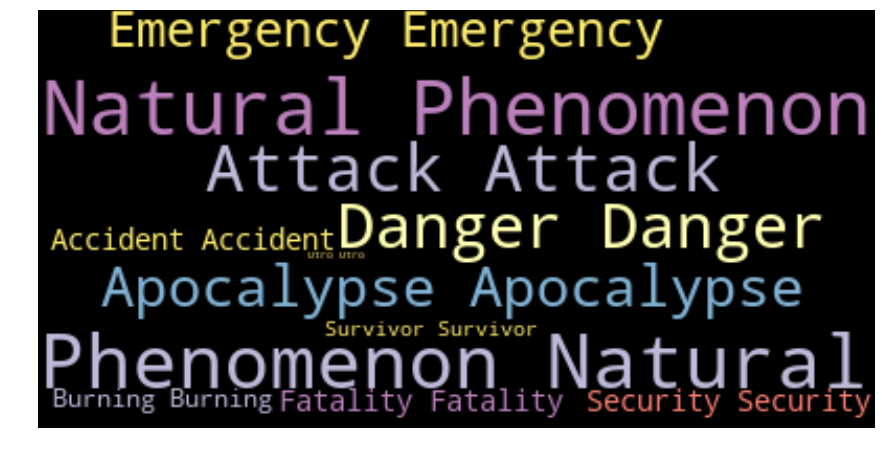

In [392]:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in df['key_global'])
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

> ####  Top 10 KeyWord casos donde no hay accidente Real 

Text(0, 0.5, 'KeyWords')

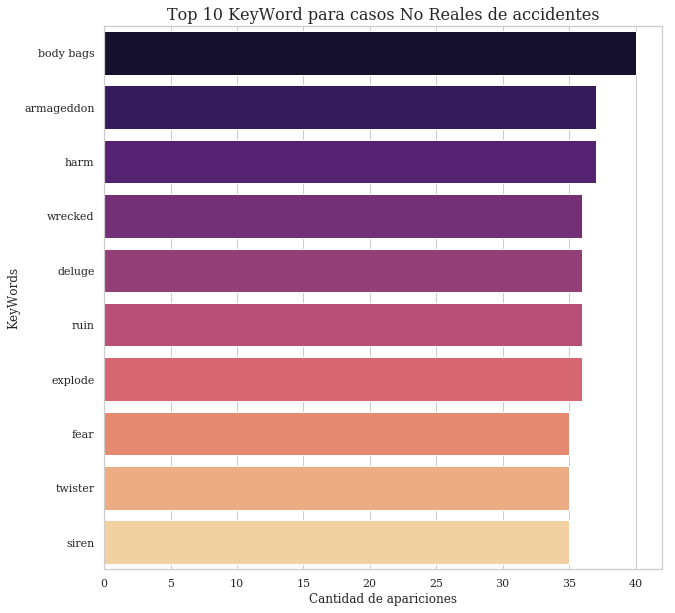

In [393]:
top_KeyWord = df.loc[df['target']== 0,'keyword'].value_counts().head(10)
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=top_KeyWord.values,y=top_KeyWord.index,orient='h',palette="magma")
grafico_top_key.set_title("Top 10 KeyWord para casos No Reales de accidentes",fontsize=16)
grafico_top_key.set_xlabel("Cantidad de apariciones",fontsize=12)
grafico_top_key.set_ylabel("KeyWords",fontsize=12)
#plt.savefig('grafico_2')

> #### Top 10 KeyWord para casos reales de accidentes

Text(0, 0.5, 'KeyWords')

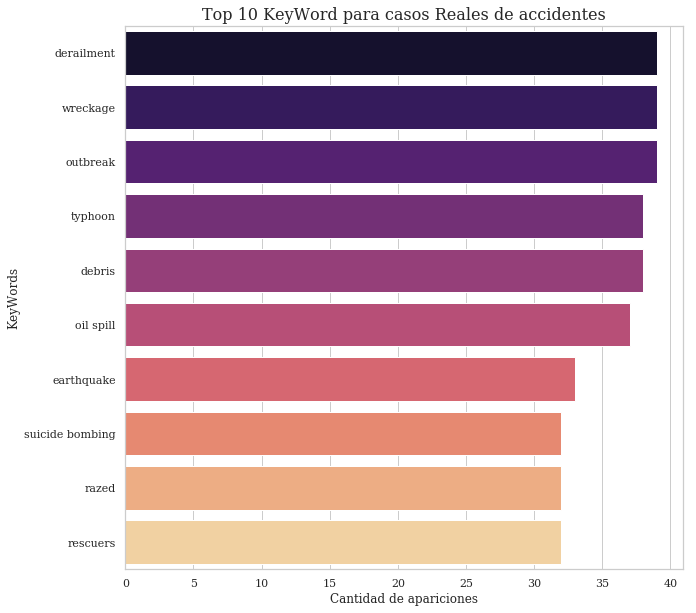

In [394]:
top_KeyWord = df.loc[df['target']== 1,'keyword'].value_counts().head(10)
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=top_KeyWord.values,y=top_KeyWord.index,orient='h',palette="magma")
grafico_top_key.set_title("Top 10 KeyWord para casos Reales de accidentes",fontsize=16)
grafico_top_key.set_xlabel("Cantidad de apariciones",fontsize=12)
grafico_top_key.set_ylabel("KeyWords",fontsize=12)
#plt.savefig('grafico_3')

### Tenemos key words exclusivas para cada target?

In [395]:
df_key = df[['id','keyword','text','target','key_global']]   
list_key_1 = list(df_key.loc[df_key['target']==1,'keyword'].unique())
list_key_0 = list(df_key.loc[df_key['target']==0,'keyword'].unique())
key_1_exclusiva = []
for key in list_key_1:
        if key not in list_key_0:
            key_1_exclusiva.append(key)
            
key_0_exclusiva = []
for key in list_key_0:
        if key not in list_key_1:
            key_0_exclusiva.append(key)  

In [396]:
key_1_exclusiva

['debris', 'derailment', 'wreckage']

In [397]:
key_0_exclusiva

['aftershock']

'Diagrama de flujo de KeyWors exclusivas para un solo target'

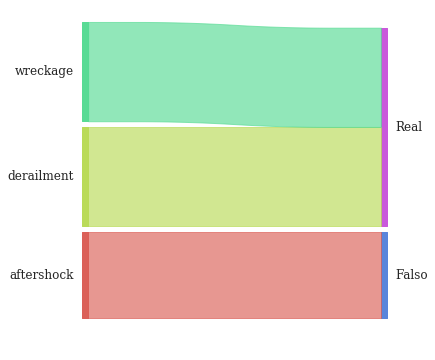

In [620]:
key_w =df.loc[(df['keyword']== 'aftershock')|(df['keyword']== 'derailment')|(df['keyword']== 'derbis')|(df['keyword']== 'wreckage'),]
from pySankey import sankey
display('Diagrama de flujo de KeyWors exclusivas para un solo target')
sankey.sankey(key_w['keyword'],key_w['Veracidad'],aspect=20, fontsize=12)

### Análisis de Twetts

>* Como se reparten las cantidades de los Tweets según sean Reales o Falsos?

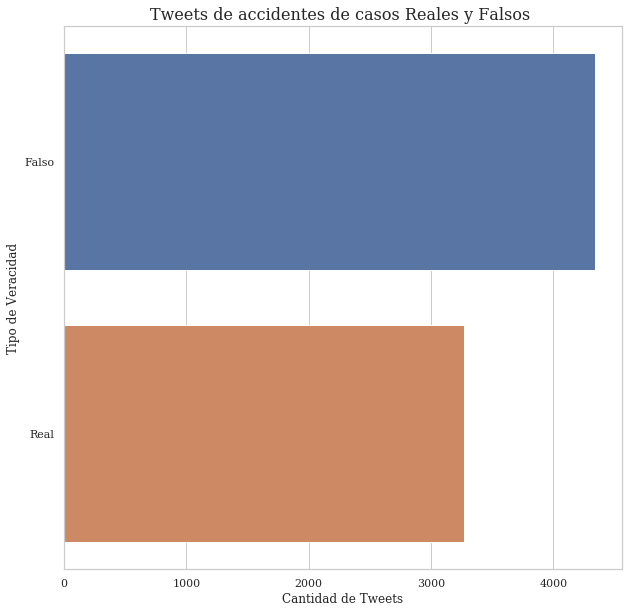

In [468]:
tweets = df['Veracidad'].value_counts()
plt.subplots(figsize=(10,10))
grafico_top_key=sns.barplot(x=tweets.values,y=tweets.index)
grafico_top_key.set_title("Tweets de accidentes de casos Reales y Falsos ",fontsize=16)
grafico_top_key.set_xlabel("Cantidad de Tweets",fontsize=12)
grafico_top_key.set_ylabel("Tipo de Veracidad",fontsize=12);
#plt.savefig('grafico_2')


>* Que cantidades de Tweets Reales o No según la Key Global tenemos?

In [400]:
df['veces'] = 1
mi_map=pd.crosstab(df['key_global'], df['Veracidad'],values=df.veces,aggfunc=np.sum)

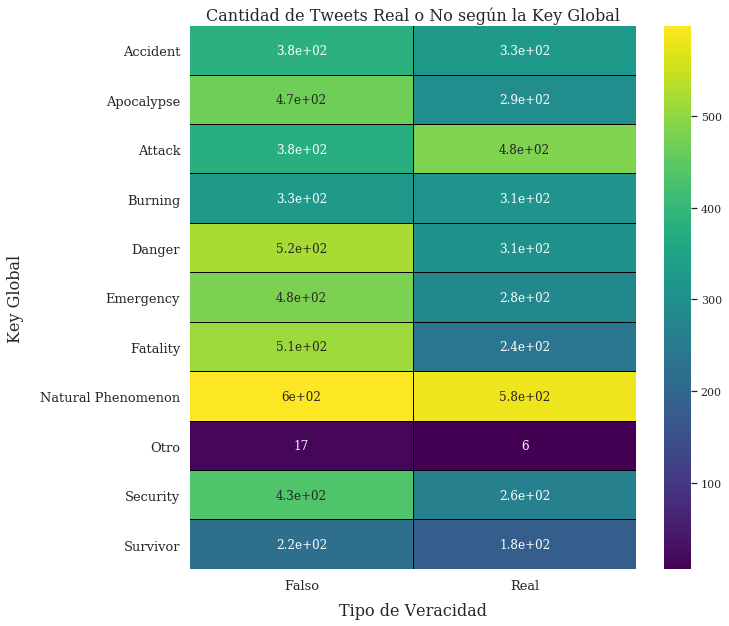

In [613]:
fig, ax = plt.subplots(figsize=(10,10))

g = sns.heatmap(mi_map, cmap="viridis", ax=ax, linewidths=0.005, linecolor='black',annot=True)
g.set_title("Cantidad de Tweets Real o No según la Key Global", fontsize=16)
g.set_xlabel("Tipo de Veracidad", fontsize=16, labelpad=10)
g.set_ylabel("Key Global", fontsize=16, labelpad=16, rotation=90)
g.set_xticklabels(g.get_xticklabels(), fontsize=13)
g.set_yticklabels(g.get_yticklabels(), fontsize=13, rotation=0)

g.title.set_position([0.5, 1.05])
plt.show()

### Cuáles son las cantidades de letras utilizadas en los Tweets, ya sea para casos Reales o Falsos?

In [521]:
text_real = " ".join(str(each) for each in df.loc[df['target']== 1,'keyword'])
text_falso = " ".join(str(each) for each in df.loc[df['target']== 0,'keyword'])

In [597]:
a = Counter(text_real)
b =  Counter(text_falso)
df_a = pd.DataFrame({'Letras':list(a.keys()),'Cantidad':list(a.values())})
df_b= pd.DataFrame({'Letras':list(b.keys()),'Cantidad':list(b.values())})

df_a['Veracidad']='Real'
df_b['Veracidad']='Falso'
df_c=pd.concat([df_a,df_b])
#Elimino casos de espacios en blancos
df_c = df_c.loc[df_c['Letras']!= ' ',:]

In [598]:
df_c.sample(10)

,Letras,Cantidad,Veracidad
24,q,61,Falso
0,o,2092,Falso
22,z,95,Real
20,y,246,Real
11,v,301,Real
12,c,1212,Real
17,p,564,Falso
21,g,867,Falso
16,m,850,Real
10,c,1325,Falso


In [599]:
df_vocales = df_c.loc[(df_c['Letras']== 'a')|(df_c['Letras']== 'e')|(df_c['Letras']== 'i')|(df_c['Letras']== 'o')|(df_c['Letras']== 'u'),:]
df_consonantes = df_c.loc[(df_c['Letras']!= 'a')&(df_c['Letras']!= 'e')&(df_c['Letras']!= 'i')&(df_c['Letras']!= 'o')&(df_c['Letras']!= 'u')]

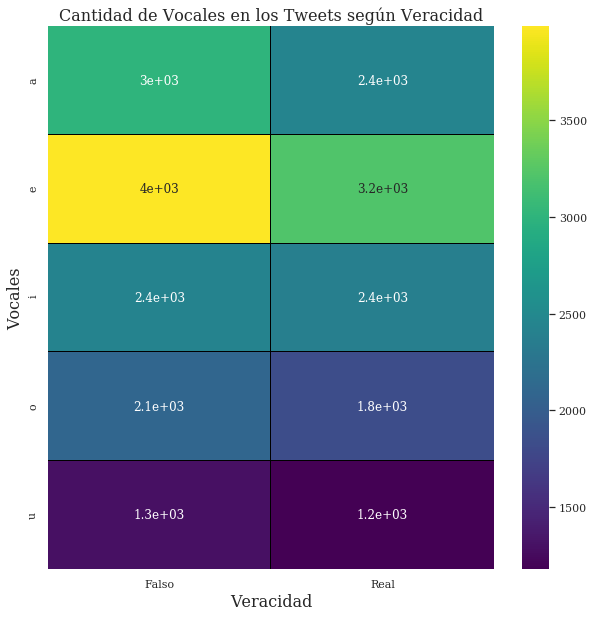

In [611]:
map_vocales = pd.crosstab(df_vocales['Letras'], df_vocales['Veracidad'],values=df_vocales.Cantidad,aggfunc=np.sum)
fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(map_vocales, cmap="viridis",ax=ax, linewidths=0.005,annot=True, linecolor='black')
g.set_title("Cantidad de Vocales en los Tweets según Veracidad", fontsize=16)
g.set_xlabel("Veracidad", fontsize=16)
g.set_ylabel("Vocales", fontsize=16, rotation=90)
g.title.set_position([0.5, 1.05])
plt.show()

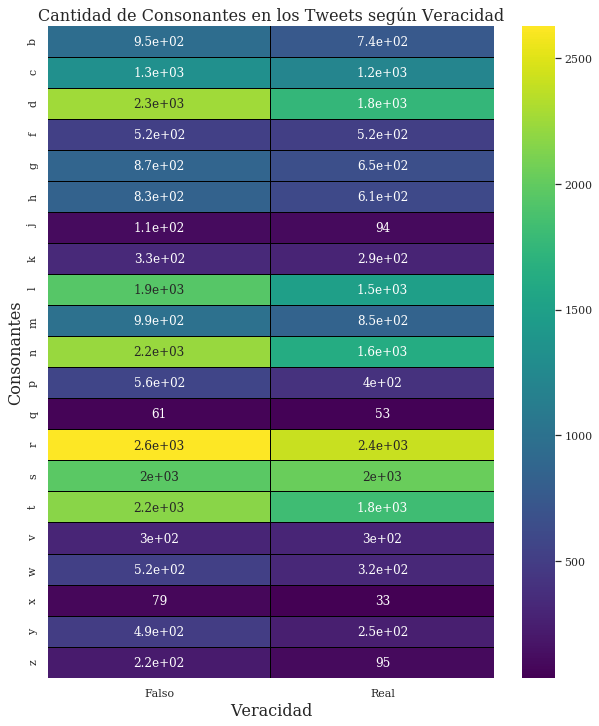

In [612]:
map_consonantes = pd.crosstab(df_consonantes['Letras'], df_consonantes['Veracidad'],values=df_consonantes.Cantidad,aggfunc=np.sum)
fig, ax = plt.subplots(figsize=(10,12))
g = sns.heatmap(map_consonantes, cmap="viridis",ax=ax, linewidths=0.005,annot=True, linecolor='black')
g.set_title("Cantidad de Consonantes en los Tweets según Veracidad", fontsize=16)
g.set_xlabel("Veracidad", fontsize=16)
g.set_ylabel("Consonantes", fontsize=16, rotation=90)
g.title.set_position([0.5, 1.05])
plt.show()

## Hay mucho cambio en los Tweets antes y despues de ser depurados?

>* Longitud de los Tweets según sean Reales o Falsos antes y despues de ser depurados

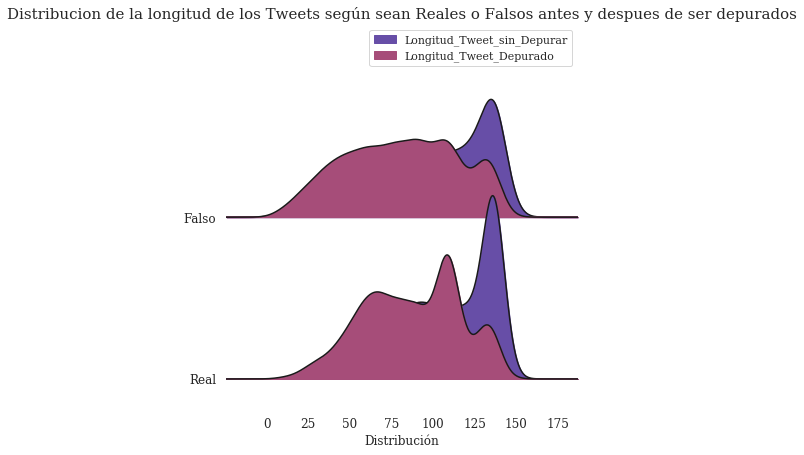

In [407]:
import joypy
fig, axes = joypy.joyplot(df, column=['Longitud_Tweet_sin_Depurar','Longitud_Tweet_Depurado'], by="Veracidad", figsize=(6,6), legend=True,color=['#674ea7', '#a64d79'],)
plt.title('Distribucion de la longitud de los Tweets según sean Reales o Falsos antes y despues de ser depurados',fontsize=15)
plt.xlabel('Distribución', fontsize=12)
plt.show()

>* Longitud de los Tweets según la Key Global antes y despues de ser depurados

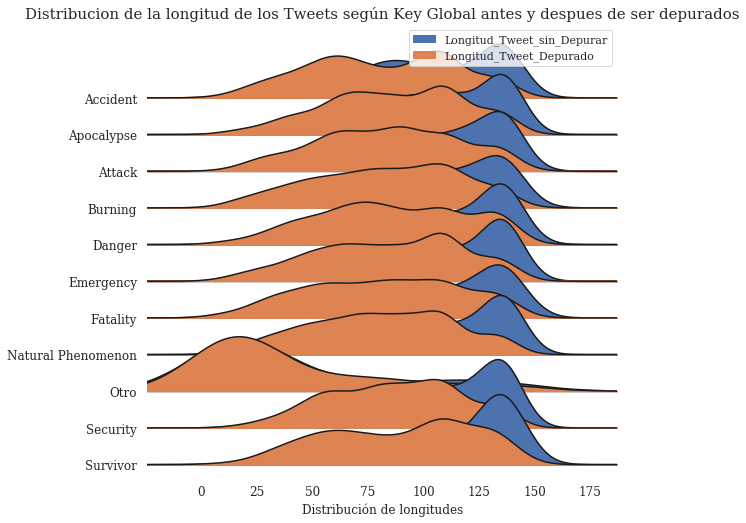

In [445]:
import joypy
fig, axes = joypy.joyplot(df, column=['Longitud_Tweet_sin_Depurar','Longitud_Tweet_Depurado'], by="key_global", legend=(True), figsize=(9,7)) #by indicates grouping by
plt.title('Distribucion de la longitud de los Tweets según Key Global antes y despues de ser depurados',fontsize=15)
plt.xlabel('Distribución de longitudes', fontsize=12)
plt.show()

## Luego de la depuración del texto de los Tweets. Cómo se distribuyen las Longitudes de los Tweets según la Key Global para casos Reales y No Reales de accidentes?

In [491]:
real = df.loc[df['target']== 1,['key_global','Longitud_Tweet_Depurado']]
falso = df.loc[df['target']== 0,['key_global','Longitud_Tweet_Depurado']]

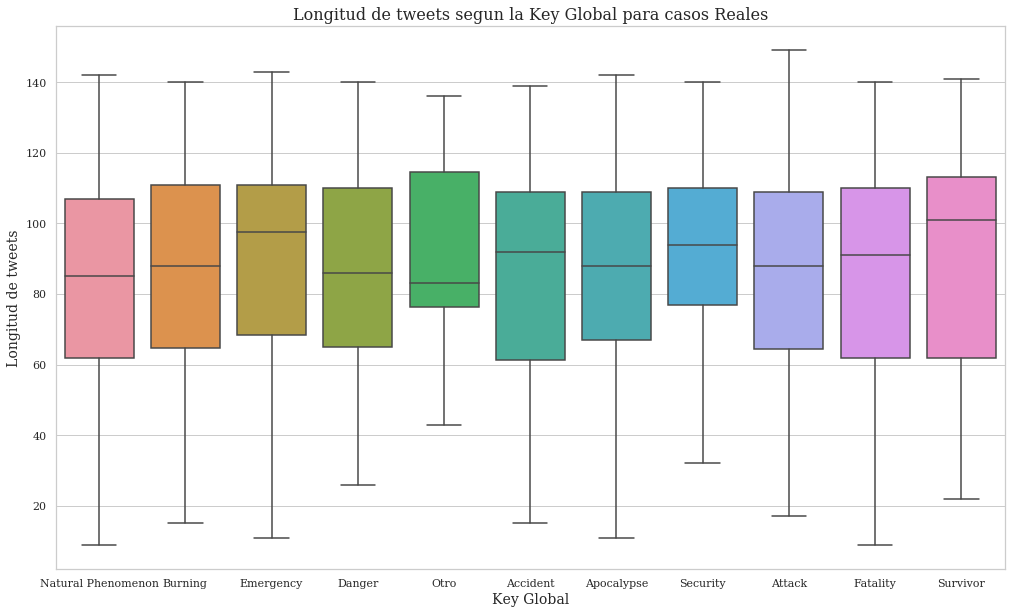

In [492]:
fig, ax = plt.subplots(figsize=(17,10))
ax = sns.boxplot(x='key_global', y='Longitud_Tweet_Depurado', data=real)
ax.set_xlabel('Key Global',fontsize=14);
ax.set_ylabel('Longitud de tweets',fontsize=14);
ax.set_title("Longitud de tweets segun la Key Global para casos Reales", fontsize=16);

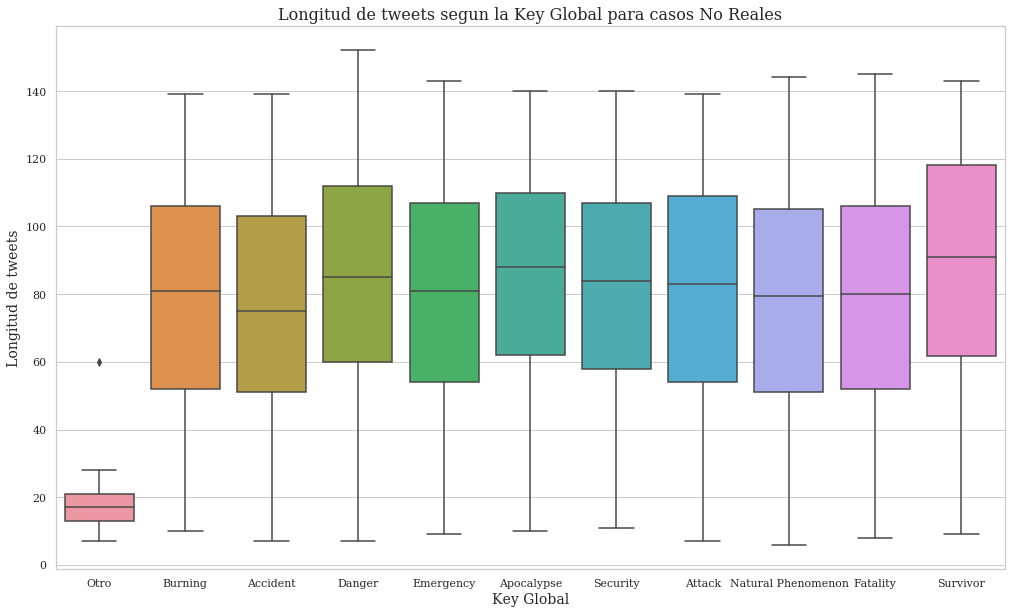

In [493]:
fig, ax = plt.subplots(figsize=(17,10))
ax = sns.boxplot(x='key_global', y='Longitud_Tweet_Depurado', data=falso)
ax.set_xlabel('Key Global',fontsize=14);
ax.set_ylabel('Longitud de tweets',fontsize=14);
ax.set_title("Longitud de tweets segun la Key Global para casos No Reales", fontsize=16);

### N-Gramas (filtrar para longitudes>=2)

In [494]:
print(set(stopwords.words('English')))

{"she's", 'both', 'each', 'we', 'from', 'themselves', 'again', 'out', 'it', 'been', 'me', 'up', 'over', 'all', "shan't", "mustn't", 'them', 'what', 'with', 'y', 'of', 'how', 'ours', 'other', 'about', 'if', 'than', 'does', 'the', 'should', 'more', 'have', 'did', 'these', 'on', 'most', 'down', 'my', 'in', 'won', 'by', 'only', 'further', 'don', "couldn't", 'weren', 'why', 'was', 'do', 'had', 'nor', 'few', "isn't", 'too', 're', "aren't", "wouldn't", 'that', 'you', 't', 'no', 'below', 'ourselves', "hasn't", 'and', 'off', 'your', 'having', 'o', "it's", 'is', 'd', 'hadn', 'here', 'under', 'shan', 'same', 'at', 'they', 'this', "don't", 'herself', 'very', "you'd", "you'll", 'so', 'couldn', "should've", "hadn't", "needn't", 'because', 'theirs', 'isn', 'haven', 'just', 'his', 'will', 'while', 'her', 'those', 'their', 'into', 'then', 'where', 'ain', 'ma', 'above', "weren't", 'doing', 'before', 'yourself', 'i', 'has', 'he', 'were', 'wouldn', 'yourselves', 'as', 'yours', 'him', 'mightn', "wasn't", '

In [495]:
mis_stopwors = list(stopwords.words('English'))
filtrado_real = []
for tweet in df.loc[df['target']== 1,'text']:
    for palabra in tweet.split():
        if palabra not in mis_stopwors:
            filtrado_real.append(palabra)

In [496]:
filtrado_no_real = []
for tweet in df.loc[df['target']== 0,'text']:
    for palabra in tweet.split():
        if palabra not in mis_stopwors:
            filtrado_no_real.append(palabra)

In [497]:
def encontrar_ngramas(palabras, n):
    lista = []
    ngramas = ngrams(palabras, n)
    for k in ngramas:
            lista.append(k)
    
    final = [(lambda x: ' '.join(x))(x) for x in lista]
    return final

### Unigrams

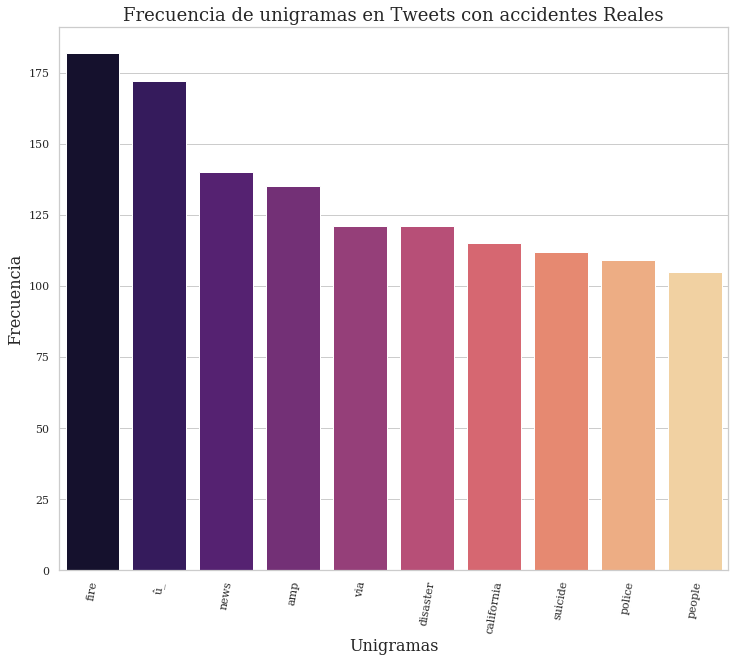

In [514]:
unigramas = encontrar_ngramas(filtrado_real, 1)
serie = pd.Series(x for x in unigramas).value_counts().head(10)
plt.figure(figsize=[12,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de unigramas en Tweets con accidentes Reales', fontsize=18)
g.set_xlabel('Unigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=80)
plt.show()

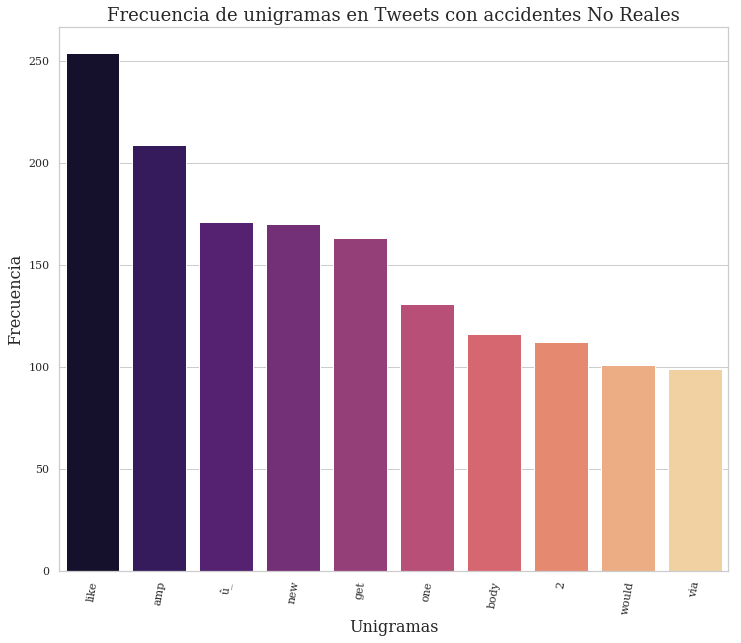

In [513]:
unigramas = encontrar_ngramas(filtrado_no_real, 1)
serie = pd.Series(x for x in unigramas).value_counts().head(10)
plt.figure(figsize=[12,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de unigramas en Tweets con accidentes No Reales', fontsize=18)
g.set_xlabel('Unigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=80)
plt.show()

### Bigramas

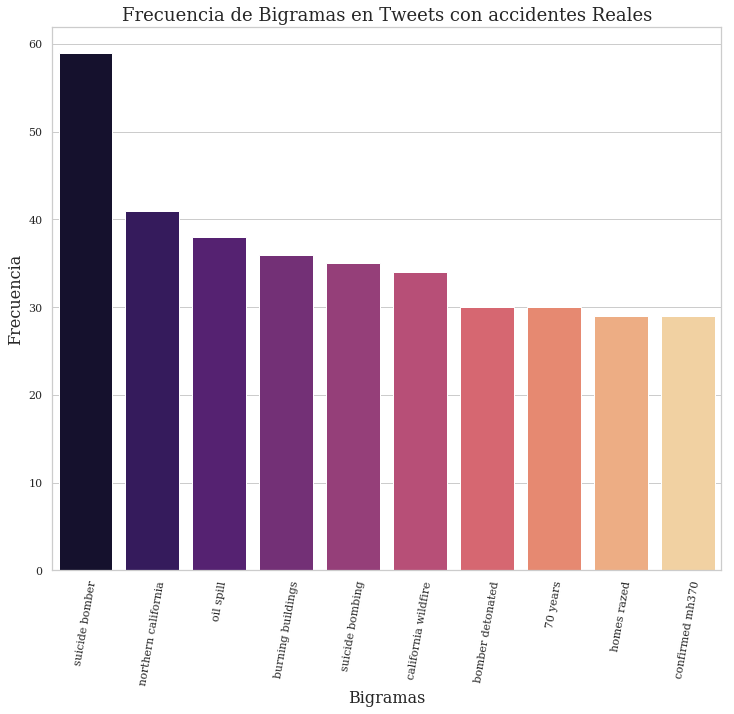

In [512]:
bi = encontrar_ngramas(filtrado_real, 2)
serie = pd.Series(x for x in bi).value_counts().head(10)
plt.figure(figsize=[12,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de Bigramas en Tweets con accidentes Reales', fontsize=18)
g.set_xlabel('Bigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=80)
plt.show()

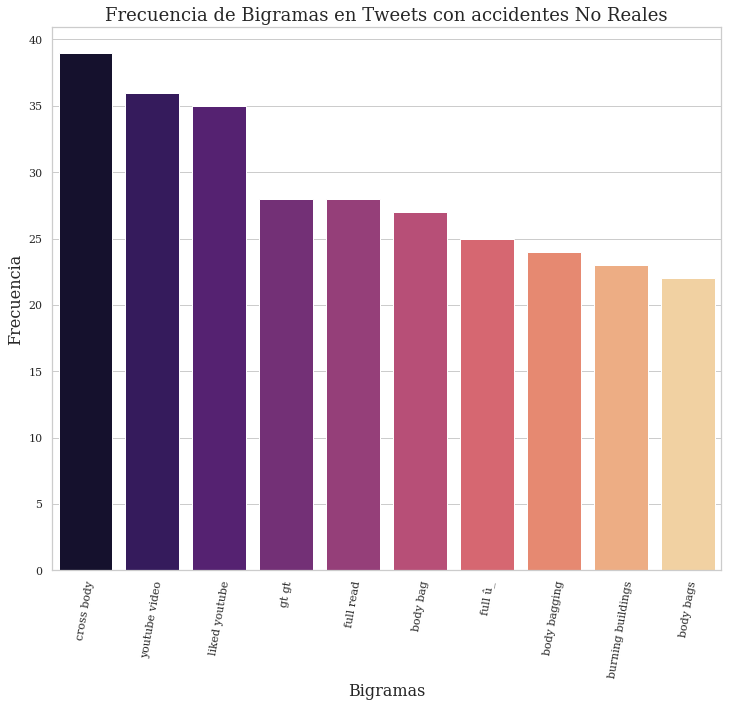

In [511]:
bi = encontrar_ngramas(filtrado_no_real, 2)
serie = pd.Series(x for x in bi).value_counts().head(10)
plt.figure(figsize=[12,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de Bigramas en Tweets con accidentes No Reales', fontsize=18)
g.set_xlabel('Bigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=80)
plt.show()

### Trigramas

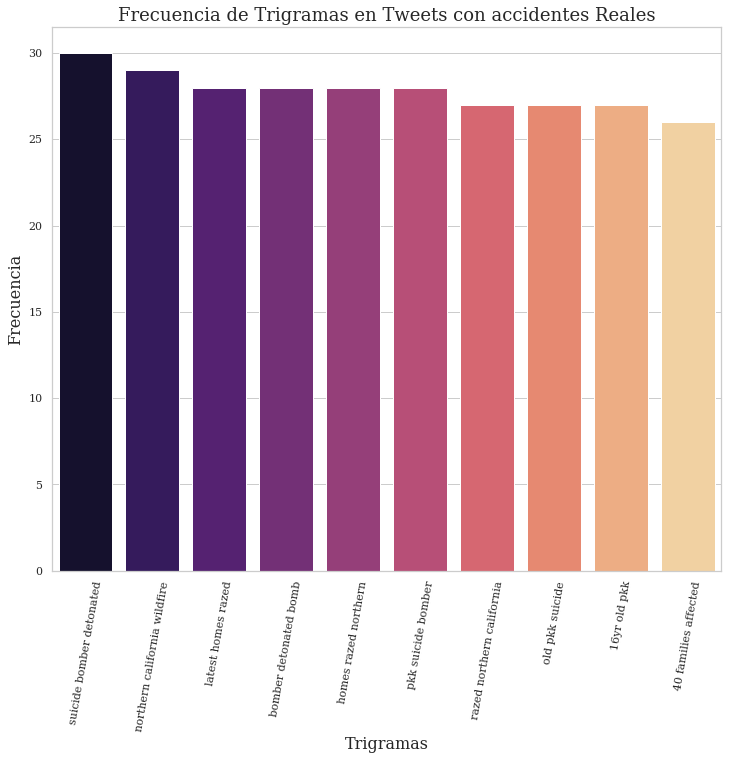

In [510]:
tri = encontrar_ngramas(filtrado_real, 3)
serie = pd.Series(x for x in tri).value_counts().head(10)
plt.figure(figsize=[12,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de Trigramas en Tweets con accidentes Reales', fontsize=18)
g.set_xlabel('Trigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=80)
plt.show()

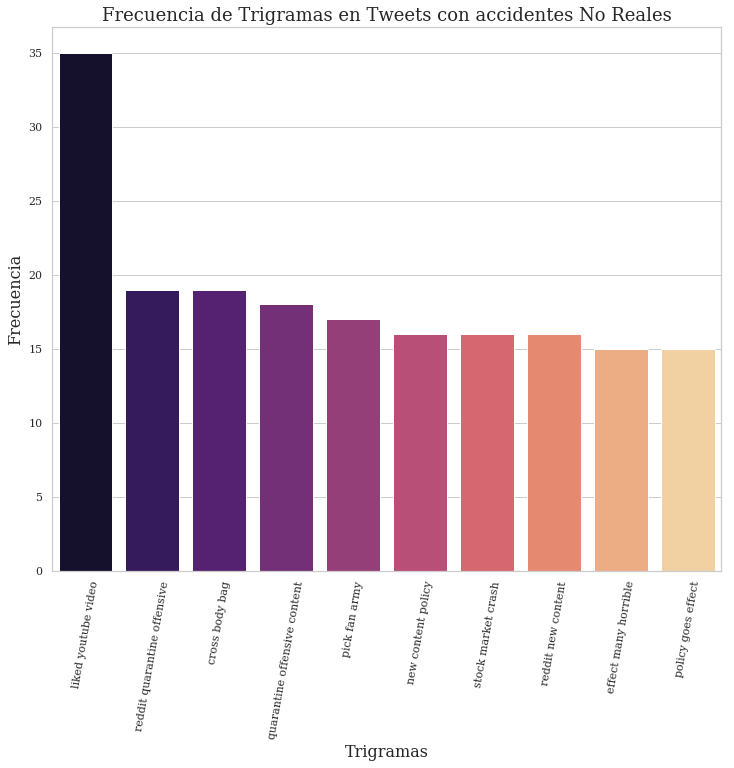

In [509]:
tri = encontrar_ngramas(filtrado_no_real, 3)
serie = pd.Series(x for x in tri).value_counts().head(10)
plt.figure(figsize=[12,10])
g = sns.barplot(x=serie.index, y=serie.values, palette='magma')
g.set_title('Frecuencia de Trigramas en Tweets con accidentes No Reales', fontsize=18)
g.set_xlabel('Trigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=80)
plt.show()